# 7/25更新
- 可以使用pretrain weight嗎? Ans: No
- 一定要使用Resnet18 model嗎? Ans: 不一定，可以使用其他model

# 常見問題：
- 沒有GPU或其他環境問題：請你使用 colab
- Train 很慢：請你檢查 get_device() 看有沒有成功使用到 GPU
- 被 colab 限制 GPU 用量：好像使用超過12小時會被 google 限制用量，
請你開其他 google 帳號，或是等個幾小時再繼續
- dimension 對不起來：請你檢查 tensor.shape
- dataset permission denied：google 有流量限制，請你嘗試其他下載連結

# Install & import packages

In [2]:
!pip install torchtoolbox

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder, CIFAR100
from torchtoolbox.tools import summary
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Check GPU

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()
print(device)
!nvidia-smi

cuda
Mon Aug  2 22:29:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   35C    P8    11W / 280W |   2251MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Download dataset

In [5]:
!pip install opendatasets


     |████████████████████████████████| 58 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 3.9 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=f67d4854d7a636eaae79afb6a0888c88d6cb7f5453912049a48ec80bf3398920
  Stored in directory: /home/U111syhuang/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle


In [6]:
import opendatasets as od

od.download('https://www.kaggle.com/c/2021-ai-training/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shihyuhuang
Your Kaggle Key: ········


100%|██████████| 140M/140M [00:07<00:00, 19.6MB/s] 



Extracting archive ./2021-ai-training/2021-ai-training.zip to ./2021-ai-training


# Dataloader

In [7]:
data_dir = './2021-ai-training/CIFAR100'
classes = os.listdir(data_dir + "/TRAIN")
print(classes)
print(len(classes))

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [8]:
# Data transforms (normalization & data augmentation)
normalize = tt.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
train_tfms = tt.Compose([
        tt.RandomCrop(32, padding=4),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        normalize,
])

valid_tfms = tt.Compose([
        tt.ToTensor(),
        normalize,
])

In [9]:
# PyTorch datasets
train_ds = ImageFolder(root=data_dir+"/TRAIN",transform=train_tfms)
valid_ds = ImageFolder(root=data_dir+"/TEST",transform=valid_tfms)

In [10]:
# PyTorch data loaders
BATCH_SIZE=64
train_dl = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=100, shuffle=False, num_workers=2)

In [11]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def adjust_learning_rate(optimizer, epoch):
    if epoch < 75:
        lrr = lr
    elif epoch < 112:
        lrr = lr * 0.1
    else:
        lrr = lr * 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lrr

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        

In [26]:

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet_Cifar(ImageClassificationBase):
    def __init__(self, growth_rate=12, block_config=(16, 16, 16),
                 num_init_features=24, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet_Cifar, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # initialize conv and bn parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=8, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out


def densenet_BC_cifar(depth, k, **kwargs):
    N = (depth - 4) // 6
    model = DenseNet_Cifar(growth_rate=k, block_config=[N, N, N], num_init_features=2*k, **kwargs)
    return model


In [27]:
import math
model = densenet_BC_cifar(depth=100, k=12, num_classes=100)

In [28]:
model = to_device(model,device)

# Set Config

In [29]:
epochs=150
lr=0.1
momentum=0.9
weight_decay=1e-4
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

# Training


In [30]:
def Train (epochs,train_dl,valid_dl,model,optimizer):
    torch.cuda.empty_cache()
    
    history = []
        
    for epoch in range(epochs):
        adjust_learning_rate(optimizer, epoch)
        model.train()
        train_loss = []
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lrs.append(get_lr(optimizer))

    
        result = evaluate(model,valid_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

@torch.no_grad()
def evaluate(model,valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [31]:
%%time
history = []
history += Train(epochs=epochs,train_dl=train_dl,valid_dl=valid_dl,model=model,optimizer=optimizer)

Epoch [0], last_lr: 0.10000, train_loss: 3.8632, val_loss: 3.5203, val_acc: 0.1678
Epoch [1], last_lr: 0.10000, train_loss: 3.0568, val_loss: 2.8238, val_acc: 0.2847
Epoch [2], last_lr: 0.10000, train_loss: 2.4879, val_loss: 2.7379, val_acc: 0.3258
Epoch [3], last_lr: 0.10000, train_loss: 2.1495, val_loss: 2.7143, val_acc: 0.3441
Epoch [4], last_lr: 0.10000, train_loss: 1.9223, val_loss: 2.0449, val_acc: 0.4613
Epoch [5], last_lr: 0.10000, train_loss: 1.7640, val_loss: 1.8641, val_acc: 0.4990
Epoch [6], last_lr: 0.10000, train_loss: 1.6384, val_loss: 1.8818, val_acc: 0.5078
Epoch [7], last_lr: 0.10000, train_loss: 1.5422, val_loss: 1.6739, val_acc: 0.5461
Epoch [8], last_lr: 0.10000, train_loss: 1.4631, val_loss: 1.7907, val_acc: 0.5355
Epoch [9], last_lr: 0.10000, train_loss: 1.3990, val_loss: 1.6894, val_acc: 0.5468
Epoch [10], last_lr: 0.10000, train_loss: 1.3463, val_loss: 1.5426, val_acc: 0.5781
Epoch [11], last_lr: 0.10000, train_loss: 1.2975, val_loss: 1.5565, val_acc: 0.5853
Ep

# Model / Parameter statistics

In [32]:
# Print model
print(model)

# Print parameter
net = densenet_BC_cifar(100, 12, num_classes=100)
input = torch.randn(1, 3, 32, 32)
summary(net,input)

DenseNet_Cifar(
  (features): Sequential(
    (conv0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

# Plot Learning curve

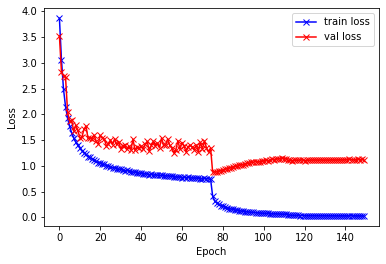

In [33]:
def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])

plot_loss(history)

# Testing

In [34]:
def test(model,data_loader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        bs = 100
        result = []
        check_names = []
        for i, (data, target) in enumerate(valid_dl):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            arr = pred.data.cpu().numpy()
            for j in range(pred.size()[0]):
                file_name = valid_ds.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,pred[j].cpu().numpy()[0])) 
        
    return result

In [35]:
result = test(model, valid_dl)

# Save Result

In [36]:
with open ('ID_result.csv','w') as f:
    f.write('Id,Category\n')
    for data in result:
        f.write(data[0]+','+str(data[1])+'\n')

In [45]:
torch.save(model.state_dict(),'midterm.pt')